## Direct Modelling
### Playing with house prices


In this notebook we explore the estimation of heteroscedastic aleatoric uncertainty through direct modelling. A simple perceptron is used to model the regression problem which outputs both the mean prediction and its standard deviation.

![house prices](datasets/real_estate/house_prices.png)

In [1]:
import tqdm
import math
import torch
import pandas as pd

In [2]:
import numpy as np
import seaborn as sns
from time import sleep
from pathlib import Path

from torch import nn
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# Paths, global vars
dt_folder = Path("./datasets")
dt_name = 'real_estate'

In [4]:
# Checks
assert dt_folder.exists()
assert dt_folder.is_dir()
assert (dt_folder / dt_name / (dt_name + '.csv')).exists()

#### Load Dataset

In [5]:
df = pd.read_csv(dt_folder / dt_name / (dt_name + '.csv'))

In [6]:
df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [7]:
df.dtypes

No                                          int64
X1 transaction date                       float64
X2 house age                              float64
X3 distance to the nearest MRT station    float64
X4 number of convenience stores             int64
X5 latitude                               float64
X6 longitude                              float64
Y house price of unit area                float64
dtype: object

#### Prepare data

In [8]:
train, test = train_test_split(df, test_size=0.2)

In [9]:
class HouseDataset(torch.utils.data.Dataset):
    def __init__(self, df, scale=False):
        x = df.iloc[:, 1:7]
        y = df.iloc[:, 7]
        if scale:
            x = StandardScaler().fit_transform(x)
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y.values)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

#### Model

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Output: pred, var
        self.layers = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
    def forward(self, x):
        return self.layers(x)

#### Train Loop

In [11]:
epochs = 200
batch_size = 64

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Adapted loss for direct modelling of aleatoric uncertainties
# From NLL with Gaussian noise
def dm_loss(output, target):
    # output: pred, var
    pred = output[:, 0]
    log_var = output[:, 1]
    var = torch.exp(0.5 * log_var) + 1e-5
    
    left = (1 / (2 * var ** 2)) * torch.abs(target - pred) ** 2
    right = (1 / 2) * torch.log(var ** 2)
    
    return torch.mean(left + right)

In [14]:
mean_batch_loss = np.array([])
torch.manual_seed(42)

dt_train = HouseDataset(train, scale=True)
train_loader = torch.utils.data.DataLoader(dt_train, batch_size=batch_size, num_workers=2)

mlp = MLP()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

mlp.train()
mlp.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [15]:
for epoch in range(epochs):
    tepoch = tqdm.tqdm(train_loader)
    tepoch.set_description(f"Epoch {epoch}")
    
    for i, obj in enumerate(tepoch):
        data, target = obj

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = mlp(data)

        loss = dm_loss(output, target)
        mean_batch_loss = np.append(mean_batch_loss, loss.item())

        loss.backward()
        optimizer.step()

        tepoch.set_postfix(loss=loss.item(), variance=torch.mean(output[:, 1]).item())
        sleep(0.1)

Epoch 199: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.93it/s, loss=2.03, variance=3.68]


<AxesSubplot:>

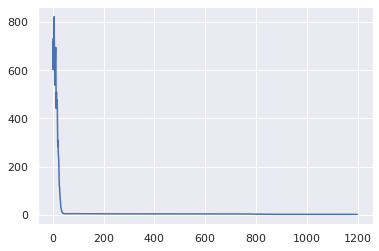

In [16]:
sns.set_theme(style="darkgrid")
sns.lineplot(data=mean_batch_loss)

#### Testing the model

In [17]:
dt_test = HouseDataset(test, scale=True)
test_loader = torch.utils.data.DataLoader(dt_test, batch_size=batch_size, num_workers=2)

In [18]:
loss = np.array([])
pred = np.array([])
var = np.array([])

mlp.eval()
mlp.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [19]:
with torch.no_grad():
    for i, obj in enumerate(test_loader):
        data, target = obj
        data, target = data.to(device), target.to(device)

        output = mlp(data)
        l = dm_loss(output, target)
        loss = np.append(loss, l.item())

        p = output[:, 0].cpu().detach().numpy()
        v = torch.exp(0.5 * output[:, 1]).cpu().detach().numpy()

        pred = np.concatenate((pred, p))
        var = np.concatenate((var, v))

In [20]:
loss

array([2.33572865, 2.53581071])

In [21]:
plot_df = test.copy()
plot_df['pred'] = pred
plot_df['var'] = var
plot_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,pred,var
359,360,2013.500,5.6,2408.99300,0,24.95505,121.55964,24.7,25.949499,4.149414
347,348,2013.583,17.4,6488.02100,1,24.95719,121.47353,11.2,21.547047,3.713718
377,378,2013.333,3.9,49.66105,8,24.95836,121.53756,56.8,50.443684,8.887039
254,255,2012.667,1.1,329.97470,5,24.98254,121.54395,51.8,55.097076,4.471071
75,76,2013.500,12.3,1360.13900,1,24.95204,121.54842,29.5,27.219774,4.491534
...,...,...,...,...,...,...,...,...,...,...
266,267,2013.250,17.8,1783.18000,3,24.96731,121.51486,23.7,26.864994,5.210341
24,25,2013.000,39.6,480.69770,4,24.97353,121.53885,38.8,40.246498,7.053996
129,130,2013.417,38.5,216.83290,7,24.98086,121.54162,41.0,45.995655,11.707796
112,113,2013.417,9.9,2102.42700,3,24.96044,121.51462,23.1,27.265467,5.792617


In [22]:
plot_df['upper'] = plot_df['pred'] + plot_df['var']
plot_df['lower'] = plot_df['pred'] - plot_df['var']

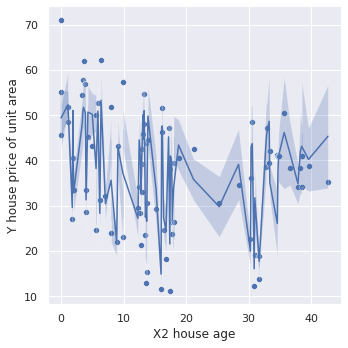

In [23]:
plot_df = plot_df.sort_values(by=['X2 house age'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df, x="X2 house age", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df, x="X2 house age", y="pred")
ax.fill_between(plot_df['X2 house age'], plot_df['lower'], plot_df['upper'], alpha=0.25)

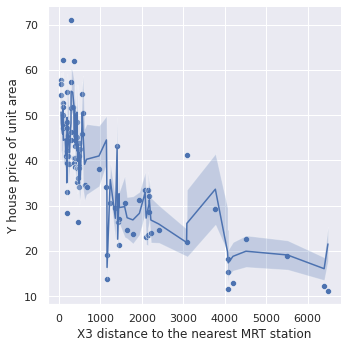

In [24]:
plot_df = plot_df.sort_values(by=['X3 distance to the nearest MRT station'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df, x="X3 distance to the nearest MRT station", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df, x="X3 distance to the nearest MRT station", y="pred")
ax.fill_between(plot_df['X3 distance to the nearest MRT station'], plot_df['lower'], plot_df['upper'], alpha=0.25)

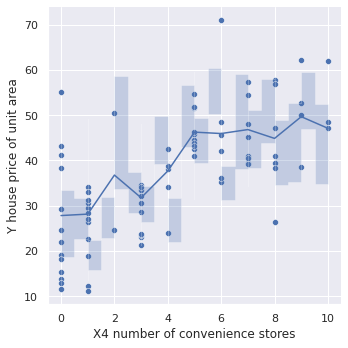

In [25]:
plot_df = plot_df.sort_values(by=['X4 number of convenience stores'])
sns.set_theme(style="darkgrid")
sns.relplot(data=plot_df, x="X4 number of convenience stores", y="Y house price of unit area")
ax = sns.lineplot(data=plot_df, x="X4 number of convenience stores", y="pred", errorbar=None)
ax.fill_between(plot_df['X4 number of convenience stores'], plot_df['lower'], plot_df['upper'], alpha=0.25, step='mid')

#### Ground-truth plots

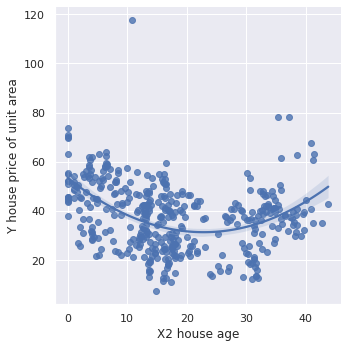

In [26]:
# All the data with ground-truth
df = df.sort_values(by=['X2 house age'])
sns.set_theme(style="darkgrid")
sns.lmplot(data=df, x="X2 house age", y="Y house price of unit area", order=2)

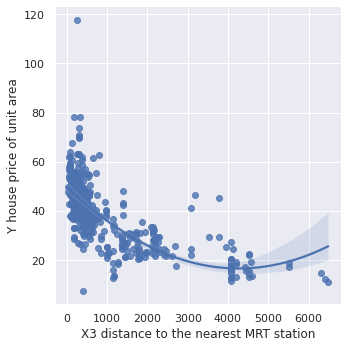

In [27]:
# All the data with ground-truth
df = df.sort_values(by=['X3 distance to the nearest MRT station'])
sns.set_theme(style="darkgrid")
sns.lmplot(data=df, x="X3 distance to the nearest MRT station", y="Y house price of unit area", order=2)

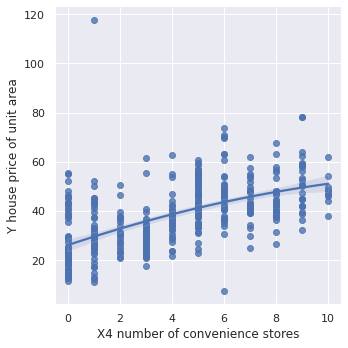

In [28]:
# All the data with ground-truth
df = df.sort_values(by=['X4 number of convenience stores'])
sns.set_theme(style="darkgrid")
sns.lmplot(data=df, x="X4 number of convenience stores", y="Y house price of unit area", order=2)